In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import os
import pandas as pd
from voxc_sv.data_loader import SpectrogramDataset, AudioDataLoader

Populating the interactive namespace from numpy and matplotlib


In [2]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/speech_commands/'
command_df = pd.read_pickle(os.path.join(dataframe_dir,'Command_Dataframe.pkl'))

In [5]:
#TODO: correct splits
all_spks = voxc_df.spk.unique()
all_sents = voxc_df.sent.unique()
uttrs_counts = voxc_df.spk.value_counts()

In [63]:
sv_spks = list(uttrs_counts.index[:10])
enroll_spks = sv_spks[:5]
test_spks = sv_spks[5:]
n_classes = len(enroll_spks)

In [20]:
enroll_uttrs = pd.DataFrame()
dev_uttrs = pd.DataFrame()
nb_enroll_uttrs = 10

# splits enroll and dev
for spk in enroll_spks:
    spk_df = command_df[command_df.spk == spk]
    assert(len(spk_df) != 0)
    enls = spk_df.sample(n=nb_enroll_uttrs)
    devs = spk_df.drop(index=enls.index).sample(n=nb_enroll_uttrs*2)
    enroll_uttrs = pd.concat([enls, enroll_uttrs])
    dev_uttrs = pd.concat([devs, dev_uttrs])

for spk in test_spks:
    spk_df = command_df[command_df.spk == spk]
    assert(len(spk_df) != 0)
    test_uttrs = spk_df.sample(n=nb_enroll_uttrs*3)

In [21]:
sample_rate = 16000
window_size = 0.025
window_stride = 0.01
window = 'hamming'
noise_dir = None
noise_prob = 0.4
noise_min = 0.0
noise_max = 0.5
vox_dir = "/home/ideal_kar/Dataset/voxceleb/"
split_file = '../../../dataset/voxceleb/Identification_split.txt'
audio_conf = dict(sample_rate=sample_rate,                                                                                                                                                            
                       window_size=window_size,                                                                                                                                                            
                       window_stride=window_stride,                                                                                                                                                        
                       window=window,                                                                                                                                                                      
                       noise_dir=noise_dir,                                                                                                                                                                
                       noise_prob=noise_prob,                                                                                                                                                              
                       noise_levels=(noise_min, noise_max))   

from voxc_sv.data_loader import SpectrogramParser
parser = SpectrogramParser(audio_conf)

In [22]:
from voxc_sv.model import siameseNet, voxNet
import torch
embedding_size = 1024
model = voxNet(1251)
checkpoint = torch.load("models/voxc/voxc_384_wo_E.pth.tar")
model.load_state_dict(checkpoint['state_dict'])
model.cuda()
model.eval()

voxNet (
  (conv1): Conv2d(1, 96, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv2d(96, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (fc6): Conv2d(256, 4096, kernel_size=[9, 1], stride=(1, 1))
  (fc6_bn): BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True)
  (fc7): Linear (4096 -> 1024)
  (fc7_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (fc8): Linear (1024 -> 12

Speaker Model

In [44]:
from torch.autograd import Variable
import torch
import numpy as np
base_dir = '/home/muncok/DL/dataset/SV_sets/speech_commands/'
embeddings = np.zeros((len(enroll_spks), embedding_size))
label_counts = np.zeros(len(enroll_spks))
for i, row in enroll_uttrs.iterrows():
    audio_path = os.path.join(base_dir, row.sent, row.file)
    audio_input = torch.zeros((512, 100))
    audio_input.narrow(1,0, 98).copy_(SpectrogramParser.parse_audio_ext(parser, audio_path))
    audio_input = Variable(audio_input.cuda())
    output = model(audio_input, 'fc7')
    emb = output[0].data.cpu().numpy()
    label = sv_spks.index(row.spk)
    embeddings[label] += emb
    label_counts[label] += 1

speaker_model = np.zeros((len(enroll_spks), embedding_size))
for i in range(len(enroll_spks)):
    speaker_model[i] = embeddings[i] / label_counts[i]

SI using speaker_models

In [48]:
from scipy.spatial.distance import cosine
def spk_verify(spk_model, test_in):
    best_score = -2
    for i in range(spk_model.shape[0]):
        signature_uni = spk_model[i]
        score = 1-cosine(test_in, signature_uni)
        if score > best_score:
            best_score = score     
            pred_spk = i
    return pred_spk, best_score

def pairwise_cosine(spk_model, test_in):
    scores = np.zeros(spk_model.shape[0])
    for i in range(spk_model.shape[0]):
        signature_uni = spk_model[i]
        scores[i] = 1-cosine(test_in, signature_uni)
    return scores

In [50]:
correct = 0
for i, row in dev_uttrs.iterrows():
    audio_path = os.path.join(base_dir, row.sent, row.file)
    audio_input = torch.zeros((512, 100))
    audio_input.narrow(1,0, 98).copy_(SpectrogramParser.parse_audio_ext(parser, audio_path))
    audio_input = Variable(audio_input.cuda())
    output = model(audio_input, 'fc7')
    emb = output[0].data.cpu().numpy()
    label = sv_spks.index(row.spk)
    embeddings[label] += emb
    pred_spk, score = spk_verify(speaker_model, emb)
    if pred_spk == label:
        correct += 1
print(correct / len(dev_uttrs))

0.87


### ROC Curve

In [113]:
score_vector = np.zeros((len(dev_uttrs)+len(test_uttrs), len(enroll_spks)))
label_vector = np.zeros((len(dev_uttrs)+len(test_uttrs), len(enroll_spks)))
embeddings = []

i = 0
for index, row in dev_uttrs.iterrows():
    audio_path = os.path.join(base_dir, row.sent, row.file)
    audio_input = torch.zeros((512, 100))
    audio_input.narrow(1,0, 98).copy_(SpectrogramParser.parse_audio_ext(parser, audio_path))
    audio_input = Variable(audio_input.cuda())
    output = model(audio_input, 'fc7')
    emb = output[0].data.cpu().numpy()
    score_vector[i, :] = pairwise_cosine(speaker_model, emb)
    label = sv_spks.index(row.spk)
    label_vector[i, label] = 1
    embeddings.append((emb, label))
    i+=1

for index, row in test_uttrs.iterrows():
    audio_path = os.path.join(base_dir, row.sent, row.file)
    audio_input = torch.zeros((512, 100))
    audio_input.narrow(1,0, 98).copy_(SpectrogramParser.parse_audio_ext(parser, audio_path))
    audio_input = Variable(audio_input.cuda())
    output = model(audio_input, 'fc7')
    emb = output[0].data.cpu().numpy()
    score_vector[i, :] = pairwise_cosine(speaker_model, emb)
    embeddings.append((emb, label))
    i+=1   

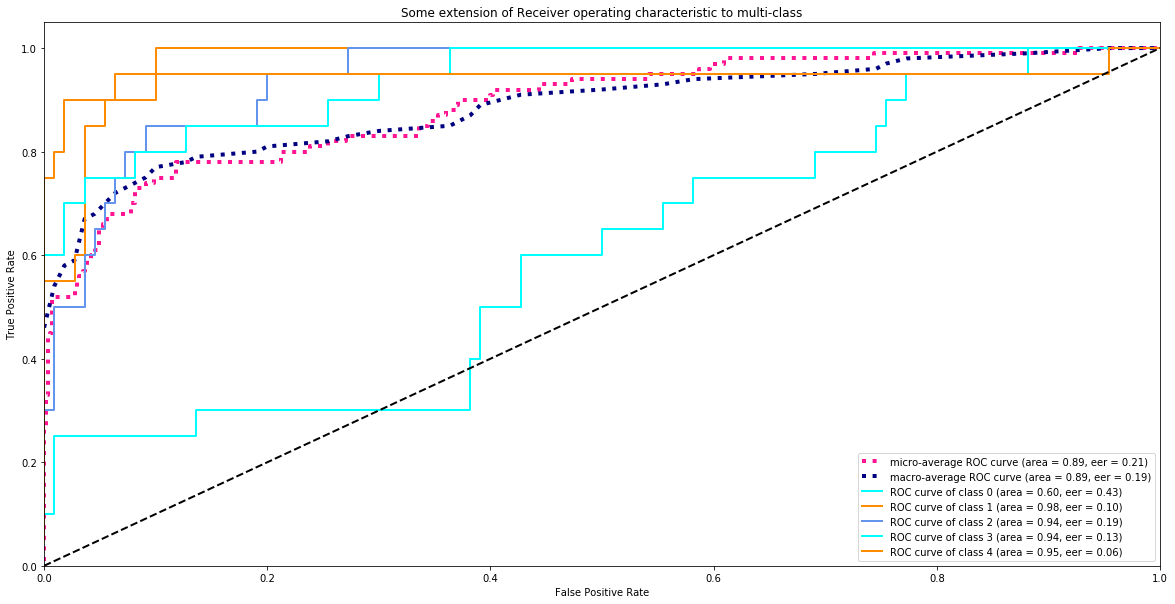

In [70]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
eer = dict()
thres = dict()
for i in range(n_classes):
    fpr[i], tpr[i], thres[i] = roc_curve(label_vector[:, i], score_vector[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], thres["micro"] = roc_curve(label_vector.ravel(), score_vector.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
eer["micro"] = fpr["micro"][np.nanargmin(np.abs(fpr["micro"] - (1 - tpr["micro"])))]

for i in range(n_classes):
    eer[i] = fpr[i][np.nanargmin(np.abs(fpr[i] - (1 - tpr[i])))]

from scipy import interp
from itertools import cycle
lw = 2
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
eer["macro"] = fpr["macro"][np.nanargmin(np.abs(fpr["macro"] - (1 - tpr["macro"])))]
# Plot all ROC curves
fig = plt.figure(figsize=(20,10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f}, eer = {1:0.2f})'
               ''.format(roc_auc["micro"], eer["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f}, eer = {1:0.2f})'
               ''.format(roc_auc["macro"], eer["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f}, eer = {2:0.2f})'
             ''.format(i, roc_auc[i], eer[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [110]:
X, y = list(zip(*embeddings))

In [96]:
len(X)

130

In [126]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clf = LDA(solver='svd')
clf.fit(X[:100], y[:100])

/home/muncok/anaconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [129]:
clf.score(X[100:],y[100:])

0.23333333333333334